**This project is due Wednesday, November 12, 2025 at 11:59 pm. Please plan ahead and submit your work on time.**

<center><h1>Grad Project #2</h1></center>

In the second project for 16.413 / 6.4132, we will continue with our "search and rescue" robot, who is charged with navigating a sometimes dangerous grid to find and help people in need. We will consider planning to navigate to, pick up, and drop off people at a hospital. You will use some of the algorithms we have already discussed in this subject, including search heuristics, MDPs, and Monte-Carlo tree search. 

The project is structured as follows: 

0. [Credit for Contributors (required)](#contributors)
1. [Pickup Agent (15 points)](#pickup)
    1. [A* in Pickup (5 points)](#Astar)
    2. [Better Heuristics for Pickup (10 points)](#heuristics)
2. [The Evolution of Fire (30 points)](#fire)
    1. [Determinized Min-cost Path Problem](#determinized_mincost)
    2. [Determinized Fire MDP Agent](#determinized_mdp)
    3. [Experiment 1 - Just Wait Determinized (15 points)](#exp_1)
    4. [Experiment 2 - What's the Right Choice? (15 points)](#choice)

3. [MCTS Agent (55 points)](#MCTS)
    1. [Implementing the MCTS Agent](#mcts_agent)
    2. [Experiment 3 - Making the Right Choice! (15 points)](#right_choice)
    3. [Benchmarks (40 points)](#benchmarks)

## <a id="contributors"></a> 0. Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this project:

Ex: I worked with Bob on MCTS.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

No other contributors

## Imports and Utilities

These are import and utility functions, and also scaffolding of functions that we have provided for you for the project.

Read through the code in the other .py files. You will need to understand the functions in those files to complete the project.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import (Iterable, Dict, Optional)
# Setup matplotlib animation
import matplotlib
from IPython.display import HTML
matplotlib.rc('animation', html='jshtml')
import random
import dataclasses
import numpy as np
from utils import *

## <a id="pickup"></a> 1. Pickup Agent (15 points)

Let us first consider a deterministic gridworld-like domain that consists of a robot, a patient and a target hospital.

![Pickup figure](just_wait.png)

The robot's goal is to pick up the patient and rescue them to the target hospital. As you can see in the above figure, the blue circle represents our robot, the orange circle represents the patient, and the red cross represents the hospital. The environment has one-way roadblocks, indicated by a flat triangle between two cells. For example, the agent can only move down from (1,1) to  (2,1) but not up. The environment also has two-way roadblocks, indicated by thick black boundaries between two cells. For example, the figure above has a long corridor formed by two walls that the agent can travel down from its initial position, but not sideways.

In the following code block, we have provided an implementation of the `PickupProblem`, in terms of states, actions and costs. 

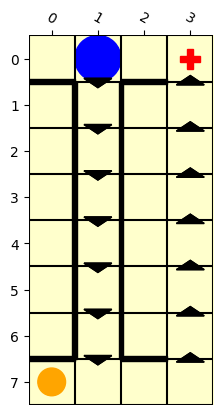

In [3]:
from pickup_problem import OneWayBlock, PickupProblem, PickupProblemState
### SET UP THE SIMPLE MAZE 

def add_wall(cell_1, cell_2, one_ways_list):
    one_ways_list.append(OneWayBlock(cell_1, cell_2))
    one_ways_list.append(OneWayBlock(cell_2, cell_1))

simple_one_ways = []
for i in range(7):
    simple_one_ways.append(OneWayBlock((i+1, 1), (i,1)))
    simple_one_ways.append(OneWayBlock((i, 3), (i+1,3)))

for i in range(1,7):
    add_wall((i,1), (i, 0), simple_one_ways)
    add_wall((i,1), (i, 2), simple_one_ways)
    # simple_one_ways.append(OneWayBlock((i, 1), (i, 0)))
    # simple_one_ways.append(OneWayBlock((i, 1), (i, 2)))
    
add_wall((0, 0), (1, 0), simple_one_ways)
add_wall((7, 0), (6, 0), simple_one_ways)
add_wall((0, 2), (1, 2), simple_one_ways)
add_wall((7, 2), (6, 2), simple_one_ways)

SimpleProblem = PickupProblem((8, 4), (0, 1), (7, 0), (0, 3), simple_one_ways)

### END OF SET UP THE SIMPLE MAZE 
SimpleProblem.render(SimpleProblem.initial)

### <a id="Astar"></a> 1A. A* In Pickup (5 points)

Please implement A* in the context of the Pickup domain using the (not very good) default heuristic that is included in the `PathCostProblem` definition. In the helper code above, we gave you a method `run_best_first_search` that takes a `PathCostProblem` as an argument. That method might be helpful to you here. 

For reference, our solution is **2** line(s) of code.

In [4]:
def run_astar_search(problem: PathCostProblem, step_budget: int = 10000) -> Tuple[List[State], List[Action], List[float], int]:
    """A* search.

    Use the implementation of `run_best_first_search` with the default heuristic.
    """
    if hasattr(problem, 'fire_process'):
        # This is a DeterminizedFireMDP - use its h method
        heuristic_fn = problem.h
    else:
        # This is a regular PickupProblem - use Manhattan distance
        def heuristic_fn(state):
            robot_loc = state.robot_loc
            hospital_loc = problem.hospital_loc
            return abs(robot_loc[0] - hospital_loc[0]) + abs(robot_loc[1] - hospital_loc[1])
    
    priority_fn = lambda node: node.g + heuristic_fn(node.state)
    return run_best_first_search(problem, priority_fn, step_budget)

In [5]:
##############################################################################################
# Make sure you run this cell before submitting! We will be grading the output of this cell! #
##############################################################################################
search_result = run_astar_search(SimpleProblem)
print("Path information:")
print("num_steps:", search_result[3])
print("path costs:",search_result[2],"total cost:",sum(search_result[2]))
print("actions found is ", search_result[1])

Path information:
num_steps: 66
path costs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] total cost: 18.0
actions found is  ['down', 'down', 'down', 'down', 'down', 'down', 'down', 'left', 'right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'up']


### <a id="heuristics"></a> 1B. Better Heuristics for Pickup (10 points)

Please come up with a better heuristic, and show that it outperforms the original heuristic. 

We have not defined in this question what it means to "outperform" here, so this is a free-form answer. You are welcome to add extra instrumentation to any of the classes to help with analysis, although our solution does not require that.  

For reference, our heuristic is **12** line(s) of code.

In [6]:
def run_astar_search_faster(problem: PathCostProblem, step_budget: int = 10000) -> Tuple[List[State], List[Action], List[float], int]:
    """A* search.
    Write a better heuristic than the default provided one
    Use your heuristic implementation with `run_best_first_search`.
    """

    def better_heuristic(state):
        robot_loc = state.robot_loc
        patient_loc = problem.patient_loc
        hospital_loc = problem.hospital_loc
        carrying = state.carried_patient
        
        if carrying:
            dist = abs(robot_loc[0] - hospital_loc[0]) + abs(robot_loc[1] - hospital_loc[1])
            return dist
        else:
            dist_to_patient = abs(robot_loc[0] - patient_loc[0]) + abs(robot_loc[1] - patient_loc[1])
            dist_patient_to_hospital = abs(patient_loc[0] - hospital_loc[0]) + abs(patient_loc[1] - hospital_loc[1])
            return dist_to_patient + dist_patient_to_hospital
    
    priority_fn = lambda node: node.g + better_heuristic(node.state)
    return run_best_first_search(problem, priority_fn, step_budget)

In [7]:
search_result = run_astar_search_faster(SimpleProblem)
# can print evidence of improvement below
# eg print(...)print("Path information:")
print("num_steps:", search_result[3])
print("path costs:",search_result[2],"total cost:",sum(search_result[2]))
print("actions found is ", search_result[1])

num_steps: 31
path costs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] total cost: 18.0
actions found is  ['down', 'down', 'down', 'down', 'down', 'down', 'down', 'left', 'right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'up']


### Answer to Question 1B
**Describe how you have improved the heuristic and how you have shown that it outperforms the original heuristic.**
<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

The default heuristic only considers the Manhattan distance from the robot's current location to the hospital, ignoring the pickup requirement. My improved heuristic accounts for the two-phase structure of the problem by returning the Manhattan distance from robot to hospital if carrying the patient, or the sum of (distance from robot to patient) plus (distance from patient to hospital) if not carrying. Both heuristics find the optimal 18-step solution, but the improved heuristic expands only 31 nodes compared to 66 nodes for the default. This demonstrates that a more informed heuristic that understands the problem structure leads to more efficient search, reducing computational cost without sacrificing solution quality since both heuristics remain admissible.

## <a id="fire"></a> 2. The Evolution of Fire (30 points)

The above problem is a deterministic search problem. But let's make the problem more interesting: Our grid now has fire. The fire starts at some initial locations (represented by red grid cells in the first figure) and evolves through time. 

Thanks to our research at MIT, we know the exact model of how fire evolves through time. 

Most notably, the fire grid at time $t$ is independent of the robot and patient, and depends only on the fire grid at the previous time step. Fire also completely ignores walls, roadblocks and the hospital.

Further, given the fire grid at time $t$, the probabilities of fire at any two different cells at time $t+1$ are independent: 
$$
P(\mathbf{F}^{t+1} \mid \mathbf{F}^t) = \prod_{(i, j) \in \mathtt{grid}} P\left(\mathbf{F}_{(i, j)}^{t+1} \mid \mathbf{F}_{(i', j') \in \mathtt{neighbors}((i, j))}^t\right),
$$ where $\mathtt{neighbors}((i, j)) = \{ (i', j') \mid  |i - i'| \le 1 \land |j - j'| \le 1 \land (i, j) \neq (i', j') \}$ is the 3 by 3 patch of cells centered at $(i, j)$, including $(i, j)$.
Further, at time $t + 1$, the probability of fire in cell $(i, j)$ is the weighted 
probability of its neighboring cells that are on fire at time $t$ for a given fixed weight matrix
$W \in \mathbb{R}^{3\times 3}$:
$$
P\left(\mathbf{F}_{(i, j)}^{t+1} \mid \mathbf{F}_{(i', j') \in \mathtt{neighbors}((i, j))}^t\right) \propto \sum_{i', j'} W[i' - i + 1, j' - j + 1] \cdot F[i', j'] .
$$

You might recognize that given the fire grid at time $t$, a matrix of 0-1 values, 
the probability of fire at time $t+1$ is the [2D convolution](http://www.songho.ca/dsp/convolution/convolution2d_example.html) of the fire grid and the weights $W$ (normalized such that the entries sum to one).

Here's another way to understand the fire process:
- We start with some initial fire grid. 
- At each time step $t$, for each cell, we randomly select a neighbor (including the current cell) with probability proportional to the weights matrix
- The current cell at time $t+1$ gets the selected neighbor's fire value at time $t$. Note that neighors outside of the grid do not have fire.

In [8]:
from fire_process import (
    FireMDP, 
    FireMDPState, 
    FireProcess,
    get_problem,
)
# Read and understand the code for these imports
# You will want to use them in your implementation

### Our Approach

We are going to adopt an online-planning approach, where at every step, our agent:
- plans according to the current state,
- executes an action, and
- observes a new state of the fire grid and replans (i.e., restarts from step one).

We will consider two different styles of planning: determinized approximation and Monte-Carlo tree search.


#### Approximate, Determinize and Replan

In our first approach, at each planning step, we will try to find an open-loop plan that is most likely to succeed.
In particular, we turn the MDP into an min-cost path problem:
- The state space no longer has the fire grid, but only contains the state of the pickup and rescue problem.
- For a step $(s_t, a, s_{t+1})$ at time $t$, we charge a cost of $c - \log \left(1 - P\left(\mathtt{on\_fire}_{t+1}(s_{t+1})\right)\right)$, where $c$ is a small cost for taking each step, and $P\left(\mathtt{on\_fire}_t(s)\right)$ is the marginal probability of stepping on fire at state $s$ at time $t$. 
- We try to find the least-cost path to reach the patient and rescue them to the hospital --- this path becomes our found open-loop plan.

Once we have a min-cost path problem, we can use A* search with a simple heuristic that ignores fire.
In particular, we will use a simple heuristic that is the sum of the manhattan distance from robot to the patient and the manhattan distance 
from patient to the hospital, scaled by the small cost `c` charged at each step. 
Note that when the robot is carrying a patient, the distance between the robot and the patient is zero.

_Hints_: 
- Before you code, try to derive the marginal probabilities of each grid cell on fire at time $t$ as an expression of the marginal probabilities of each grid cell on fire at time $t-1$. What do you find? More concretely, you may start small: Consider a grid consisting of only two cells, named $X$ and $Y$, and assume that $W$ is uniform. Then, try to write the marginal probability of cell $P(X_t=1 | X_0, Y_0)$ as an expression of $P(X_{t-1}=1 | X_0, Y_0)$ and $P(Y_{t-1}=1 | X_0, Y_0)$.
- We can formulate the A* state as $(\mathtt{robot\_loc}, \text{carrying\_patient}, \mathtt{time})$ and use time as an index into a precomputed sequence of the marginal probabilities that each cell is on fire. See `DeterminizedFireMDPState` and `DeterminizedFireMDP` for more details.

### <a id="determinized_mincost"></a> 2A. Determinized Min-cost Path Problem

Please complete the implementation of `DeterminizedFireMDP`. In particular, you should:
- Complete the function `fire_dist_at_time` to compute the log-likelihood of each cell being on fire at time $t$ given the true fire state at time $0$. 
- Using your implementation of `fire_dist_at_time`, complete the function `step_cost`.
- Complete the rest of the `DeterminizedFireMDP` and implement the heuristic function `h` based on description above. It might look remarkably similar to your heuristic from question 1B, the only difference being that `DeterminizedFireMDP` contains a `PathCostProblem`. 
    

For reference, our solution is **91** line(s) of code, including the code we have provided for you. 

In [12]:
import dataclasses
from typing import Dict, Iterable
import numpy as np
import scipy.signal

@dataclasses.dataclass(frozen=True, eq=True, order=True)
class DeterminizedFireMDPState(PickupProblemState):
  """A state for the DeterminizedFireMDP.
    
    The state is a pair of the PickupProblemState and a time step $t$.
    """
  time: int = 0

@dataclasses.dataclass(frozen=True)
class DeterminizedFireMDP(PathCostProblem):
    """Determinized version of the fire MDP --- tries to find the solution path
    that is most likely to succeed.
    """
    pickup_problem: PickupProblem
    fire_process: FireProcess
    # Additional cost for each step.
    # Can be 0 but we might have 0-cost arcs if the success probability is 1.
    action_cost = 1e-6
    # Use this to cache precomputed fire distributions, so we don't have to recompute them.
    fire_dists_cache: Dict[int, np.ndarray] = dataclasses.field(
        init=False,
        default_factory=dict,
    )
    # Override initial state if needed (for replanning with correct carried_patient status)
    _initial_state: DeterminizedFireMDPState = None
    
    def __post_init__(self):
        assert (self.pickup_problem.grid_shape ==
                self.fire_process.initial_fire_grid.shape)
    
    @property
    def initial(self) -> DeterminizedFireMDPState:
        if self._initial_state is not None:
            return self._initial_state
        return DeterminizedFireMDPState(
            *dataclasses.astuple(self.pickup_problem.initial),
            time=0,
        )
    
    def actions(self, state: DeterminizedFireMDPState) -> Iterable[Action]:
        """Actions available from the pickup problem."""
        # Extract the PickupProblemState part (without time)
        pickup_state = PickupProblemState(state.robot_loc, state.carried_patient)
        return self.pickup_problem.actions(pickup_state)
    
    def step(self, state: DeterminizedFireMDPState, action: Action) -> State:
        """We automatically pick up patient if we're on that square."""
        # Extract the PickupProblemState part
        pickup_state = PickupProblemState(state.robot_loc, state.carried_patient)
        # Get next pickup state
        next_pickup_state = self.pickup_problem.step(pickup_state, action)
        # Return new state with incremented time
        return DeterminizedFireMDPState(
            next_pickup_state.robot_loc,
            next_pickup_state.carried_patient,
            state.time + 1
        )
    
    def goal_test(self, state: DeterminizedFireMDPState) -> bool:
        """True if at hospital and holding patient."""
        pickup_state = PickupProblemState(state.robot_loc, state.carried_patient)
        return self.pickup_problem.goal_test(pickup_state)
    
    def step_cost(self, state1: DeterminizedFireMDPState, action: Action,
                  state2: DeterminizedFireMDPState) -> float:
        """
        Cost is: action_cost - log(1 - P(on_fire))
        where P(on_fire) is the probability of the robot being on fire at state2
        """
        # Get fire distribution at time t+1
        fire_dist = self.fire_dist_at_time(state2.time)
        
        # Get probability of fire at robot's next location
        robot_loc = state2.robot_loc
        prob_fire = fire_dist[robot_loc]
        
        # Clip probability to avoid log(0) issues
        prob_fire = np.clip(prob_fire, 0, 1 - 1e-10)
        
        # Cost is action_cost - log(1 - prob_fire)
        cost = self.action_cost - np.log(1 - prob_fire)
        
        return cost
    
    def fire_dist_at_time(self, t: int) -> np.ndarray:
        """
        Return the marginal distribution of fire grid at time $t$.
        This should populate and use caching in self.fire_dists_cache.
        
        Key insight: The marginal probability distribution at time t can be
        computed by convolving the distribution at time t-1 with the normalized
        weight matrix W.
        """
        # Check cache first
        if t in self.fire_dists_cache:
            return self.fire_dists_cache[t]
        
        # Base case: t = 0
        if t == 0:
            # Initial fire grid (0s and 1s)
            self.fire_dists_cache[0] = self.fire_process.initial_fire_grid.astype(float)
            return self.fire_dists_cache[0]
        
        # Recursive case: compute from t-1
        prev_dist = self.fire_dist_at_time(t - 1)
        
        # Get normalized weights - use the cached property from FireProcess
        weights = self.fire_process.normalized_fire_weights
        
        # Convolve to get next time step's distribution
        # Use scipy.signal.convolve2d like FireProcess does
        next_dist = scipy.signal.convolve2d(
            prev_dist, weights, mode='same', boundary='fill', fillvalue=0.0
        )
        
        # Clip to [0, 1] to ensure valid probabilities
        next_dist = np.clip(next_dist, 0, 1)
        
        # Cache and return
        self.fire_dists_cache[t] = next_dist
        return next_dist
    
    def h(self, state: DeterminizedFireMDPState) -> float:
        """
        Heuristic based on the manhattan distance to the patient and hospital.
        Similar to the pickup problem heuristic from 1B, scaled by action_cost.
        """
        robot_loc = state.robot_loc
        patient_loc = self.pickup_problem.patient_loc
        hospital_loc = self.pickup_problem.hospital_loc
        carrying = state.carried_patient
        
        if carrying:
            # Just need to reach hospital
            dist = abs(robot_loc[0] - hospital_loc[0]) + abs(robot_loc[1] - hospital_loc[1])
        else:
            # Need to reach patient, then hospital
            dist_to_patient = abs(robot_loc[0] - patient_loc[0]) + abs(robot_loc[1] - patient_loc[1])
            dist_patient_to_hospital = abs(patient_loc[0] - hospital_loc[0]) + abs(patient_loc[1] - hospital_loc[1])
            dist = dist_to_patient + dist_patient_to_hospital
        
        # Scale by action_cost (the minimum cost per step)
        return dist * self.action_cost

### <a id="determinized_mdp"></a> 2B. Determinized Fire MDP Agent

Please complete the implementation of FireMDPDeterminizedAStarAgent. Note that we have filled in most of the implementation for you --- including the call to `run_astar_search` from section 1. All you need to implement is the determinized_problem method. *Hint: the [`dataclasses.replace()`](https://elshad-karimov.medium.com/pythons-dataclasses-replace-a-hidden-gem-for-immutable-data-handling-e10a82f6260b) method may be useful*

For reference, our solution is **36** line(s) of code, including the code we have provided. 

In [13]:
@dataclasses.dataclass(frozen=True)
class FireMDPDeterminizedAStarAgent(Agent):
    """Agent that uses A* to plan a path to the goal in a determinized
    version of the problem. Does not need any internal state since we
    re-determinize the problem at each step.
    """

    problem: FireMDP
    step_budget: int = 10000
    
    def determinized_problem(self, state: FireMDPState) -> DeterminizedFireMDP:
        """Returns a determinized approximation of the fire MDP.
        
        Creates a DeterminizedFireMDP where:
        - The pickup problem reflects the current robot and patient state
        - The fire process starts from the current observed fire grid
        - Time starts at 0 (since we're replanning from current state)
        """
        # Create a new pickup problem with current robot location
        new_pickup_problem = dataclasses.replace(
            self.problem.pickup_problem,
            initial_robot_loc=state.robot_loc,
        )
        
        # Create a new fire process with current fire grid as initial state
        new_fire_process = dataclasses.replace(
            self.problem.fire_process,
            initial_fire_grid=state.fire_grid,
        )
        
        # Create the correct initial state preserving carried_patient status
        initial_state = DeterminizedFireMDPState(
            robot_loc=state.robot_loc,
            carried_patient=state.carried_patient,
            time=0
        )
        
        # Create the determinized problem with explicit initial state
        determinized = DeterminizedFireMDP(
            pickup_problem=new_pickup_problem,
            fire_process=new_fire_process,
            _initial_state=initial_state,
        )
        
        return determinized
        
    def act(self, state: FireMDPState) -> Action:
        problem = self.determinized_problem(state)
        try:
            plan = run_astar_search(problem, self.step_budget)
        except SearchFailed:
            print("Search failed, performing a random action")
            return random.choice(list(self.problem.actions(state)))
        return plan[1][0]

Now that we have the agent, let's try to experiment with it in some sample environments!

We have provided you with various environments defined in the the `get_problem` function.
Try to run your agent in each provided environment several times. 
You can visualize the agent's behavior using the `run_agent_on_problem` and `animate_trajectory` functions.

Let's take a closer look at the particular MDP of `get_problem("just_wait")`. 
You might ask yourself: what is your agent's behavior (on average)? 
In particular, does the robot "wait" by patrolling in the top row for a while, 
and then moves out to rescue the patient? 
If not, then it is very likely that your agent implementation is buggy! 


### <a id="exp_1"></a> 2C. Experiment 1 - Just Wait Determinized (15 points) ###
Please generate an animation of a **successful run** (i.e., the robot successfully brings the patient to the hospital) of the agent in the just_wait MDP, but **the fire does not completely die out when the robot moves down from the top row**. You might need to repeat the experiment a few times to produce this animation. If you failed to create this animation after a handful of trials (say, 15), your agent implementation might be buggy. Please feel free to reach out to us anytime if you get stuck.

Submit the animation as **just_wait_determinized.mp4**. Videos in the jupyter notebook **are not supported**, so you will need to submit the video separately.

You can view a video of the animated trajectory in the notebook by running the following code. Again, these videos will **not** be visible to the graders, so you will need to save and submit the video separately.
```python
HTML(animate_trajectory(...).to_html5_video())
```
To save the video to a file, you can use the following code:
```python
animate_trajectory(...).save("just_wait_determinized.mp4")
```


Running trials to find suitable trajectory...

Trial 1/20
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=left reward=0.0 total_reward=0.0
Action=righ


Trajectory Statistics:
  Total steps: 46
  Actions: ['left', 'right', 'left', 'right', 'left', 'right', 'left', 'right', 'left', 'right', 'left', 'right', 'left', 'right', 'left', 'right', 'left', 'right', 'left', 'right']...
  Total reward: 0.9550199818235595
  Steps spent waiting in top row: 29


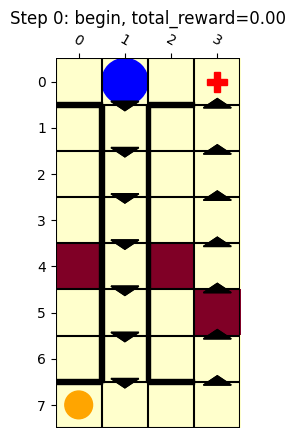

In [19]:
"""
Experiment 1: Generate animation for just_wait problem with determinized agent
"""
from IPython.display import HTML
import numpy as np

# Get the just_wait problem
problem = get_problem("just_wait")

# Create the determinized A* agent
agent = FireMDPDeterminizedAStarAgent(problem=problem)

def check_fire_when_moving_down(states, actions):
    """
    Check if fire is still present when robot moves down from top row.
    Returns True if we successfully rescue patient AND fire doesn't die out.
    """
    # Check if mission was successful
    final_state = states[-1]
    if not problem.succeeded(final_state):
        return False, "Mission failed"
    
    # Find when robot first moves down from row 0
    for i, (state, action) in enumerate(zip(states[:-1], actions)):
        if state.robot_loc[0] == 0 and action == 'down':
            # Check if there's still fire in the grid at this time
            fire_count = np.sum(state.fire_grid)
            if fire_count > 0:
                return True, f"Success! Fire present (count={fire_count}) when moving down at step {i}"
    
    return False, "Fire died out before robot moved down"

# Run multiple trials
print("Running trials to find suitable trajectory...")
max_trials = 20
suitable_trajectory = None

for trial in range(max_trials):
    print(f"\nTrial {trial + 1}/{max_trials}")
    
    # Run the agent
    result = run_agent_on_problem(problem, agent)
    states = result[0]
    actions = result[1]
    rewards = result[2] if len(result) > 2 else None
    
    # Check criteria
    is_suitable, message = check_fire_when_moving_down(states, actions)
    print(f"  {message}")
    print(f"  Total steps: {len(actions)}")
    print(f"  Final state: robot at {states[-1].robot_loc}, "
          f"carrying={states[-1].carried_patient}, "
          f"at hospital={states[-1].robot_loc == problem.pickup_problem.hospital_loc}")
    
    if is_suitable:
        suitable_trajectory = (states, actions, rewards)
        print(f"\n✓ Found suitable trajectory on trial {trial + 1}!")
        break

if suitable_trajectory is None:
    print(f"\n✗ Could not find suitable trajectory in {max_trials} trials.")
    print("Your implementation might have issues, or you can try running more trials.")
else:
    # Generate and save animation
    print("\nGenerating animation...")
    states, actions, rewards = suitable_trajectory
    anim = animate_trajectory(problem, (states, actions, rewards))
    
    # Save to file
    filename = "just_wait_determinized.mp4"
    anim.save(filename)
    print(f"Animation saved to {filename}")
    
    # Display in notebook (for viewing, won't be submitted)
    print("\nDisplaying animation in notebook:")
    display(HTML(anim.to_html5_video()))
    
    # Print some statistics about the trajectory
    print(f"\nTrajectory Statistics:")
    print(f"  Total steps: {len(actions)}")
    print(f"  Actions: {actions[:20]}..." if len(actions) > 20 else f"  Actions: {actions}")
    if rewards:
        print(f"  Total reward: {rewards}")
    
    # Count how long robot waited in top row
    wait_steps = 0
    for state, action in zip(states, actions):
        if state.robot_loc[0] == 0:
            wait_steps += 1
        else:
            break
    print(f"  Steps spent waiting in top row: {wait_steps}")

### <a id="choice"></a> 2D. Experiment 2 - What's the Right Choice? (15 points) ###

Sometimes our determinized agent finds a plan that is not optimal. To see the above effect, try to run the determinized agent in the MDP get_problem("the_choice"). In this environment, the agent faces a choice of going `right` or `down` from the initial location.

It may choose the shortcut by taking the `down` action. But, it risks getting close to the fire next to the one-way passage, and it cannot hide from the fire in this passage.

It may also accept the challenge by taking the `right` action. Here, the robot moves to a large room with more fire than the one-way passage. But it can move around to avoid fire until it finds a clear path to rescue the patient.

Similar to experiment 1, please visualize the behavior of the determinized planning agent in this environment, and generate an animation of **a successful run**. What choice does your determinized agent make?

Submit the animation as **the_choice_determinized.mp4**. 

Running trials to find successful trajectory...

Trial 1/20
Action=down reward=0.0 total_reward=0.0
Action=down reward=0.0 total_reward=0.0
Action=down reward=-1 total_reward=-0.997002999
  Result: FAILED
  Total steps: 3
  Final state: robot at (5, 0), carrying=False
  Total reward: -0.997002999
  First action: down
  → Agent chose the SHORTCUT (down through one-way passage)

Trial 2/20
Action=down reward=0.0 total_reward=0.0
Action=down reward=-1 total_reward=-0.998001
  Result: FAILED
  Total steps: 2
  Final state: robot at (4, 0), carrying=False
  Total reward: -0.998001
  First action: down
  → Agent chose the SHORTCUT (down through one-way passage)

Trial 3/20
Action=down reward=0.0 total_reward=0.0
Action=down reward=0.0 total_reward=0.0
Action=down reward=0.0 total_reward=0.0
Action=down reward=0.0 total_reward=0.0
Action=down reward=0.0 total_reward=0.0
Action=down reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Action=right reward=0.0 total_reward=0.0
Ac


Trajectory Statistics:
  Total steps: 10
  First 10 actions: ['down', 'down', 'down', 'down', 'down', 'down', 'right', 'right', 'right', 'left']
  Last 10 actions: ['down', 'down', 'down', 'down', 'down', 'down', 'right', 'right', 'right', 'left']
  Total reward: 0.9900448802097482

📊 Decision Analysis:
  The agent chose to go DOWN (the shortcut route)
  This path goes through the one-way passage
  with less room to maneuver but potentially less fire


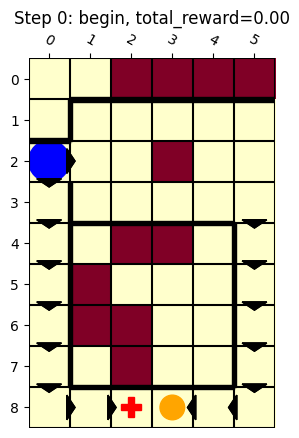

In [20]:
"""
Experiment 2: Generate animation for the_choice problem with determinized agent
"""
from IPython.display import HTML
import numpy as np

# Get the_choice problem
problem = get_problem("the_choice")

# Create the determinized A* agent
agent = FireMDPDeterminizedAStarAgent(problem=problem)

# Run multiple trials to find a successful run
print("Running trials to find successful trajectory...")
max_trials = 20
successful_trajectory = None

for trial in range(max_trials):
    print(f"\nTrial {trial + 1}/{max_trials}")
    
    # Run the agent
    result = run_agent_on_problem(problem, agent)
    states = result[0]
    actions = result[1]
    rewards = result[2] if len(result) > 2 else None
    
    # Check if successful
    final_state = states[-1]
    is_successful = problem.succeeded(final_state)
    
    print(f"  Result: {'SUCCESS' if is_successful else 'FAILED'}")
    print(f"  Total steps: {len(actions)}")
    print(f"  Final state: robot at {final_state.robot_loc}, "
          f"carrying={final_state.carried_patient}")
    
    if rewards is not None:
        print(f"  Total reward: {rewards}")
    
    # Check which choice the agent made (right or down from initial position)
    if len(actions) > 0:
        first_action = actions[0]
        print(f"  First action: {first_action}")
        if first_action == 'right':
            print(f"  → Agent chose the CHALLENGE (right into large room)")
        elif first_action == 'down':
            print(f"  → Agent chose the SHORTCUT (down through one-way passage)")
    
    if is_successful:
        successful_trajectory = (states, actions, rewards)
        print(f"\n✓ Found successful trajectory on trial {trial + 1}!")
        break

if successful_trajectory is None:
    print(f"\n✗ Could not find successful trajectory in {max_trials} trials.")
    print("Try running more trials or check your implementation.")
else:
    # Generate and save animation
    print("\nGenerating animation...")
    states, actions, rewards = successful_trajectory
    anim = animate_trajectory(problem, (states, actions, rewards))
    
    # Save to file
    filename = "the_choice_determinized.mp4"
    anim.save(filename)
    print(f"Animation saved to {filename}")
    
    # Display in notebook (for viewing, won't be submitted)
    print("\nDisplaying animation in notebook:")
    display(HTML(anim.to_html5_video()))
    
    # Print statistics about the trajectory
    print(f"\nTrajectory Statistics:")
    print(f"  Total steps: {len(actions)}")
    print(f"  First 10 actions: {actions[:10]}")
    print(f"  Last 10 actions: {actions[-10:]}")
    if rewards is not None:
        print(f"  Total reward: {rewards}")
    
    # Determine which path was taken
    first_action = actions[0]
    if first_action == 'right':
        print(f"\n📊 Decision Analysis:")
        print(f"  The agent chose to go RIGHT (the challenge route)")
        print(f"  This path goes through the large room with more fire")
        print(f"  but allows more flexibility to dodge fire")
    elif first_action == 'down':
        print(f"\n📊 Decision Analysis:")
        print(f"  The agent chose to go DOWN (the shortcut route)")
        print(f"  This path goes through the one-way passage")
        print(f"  with less room to maneuver but potentially less fire")

### Answer to Question 2D
**What choice does your determinized agent make?**
<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

The determinized agent chose to go DOWN, taking the shortcut through the one-way passage. The agent consistently made this choice across multiple trials, though it only succeeded on the 4th attempt due to stochastic fire evolution. The determinized planner evaluates expected costs by computing fire propagation probabilities and determined that the shortcut route had lower expected cost despite offering less room to maneuver. However, the fact that the agent failed 3 out of 4 times before succeeding suggests that the determinized approach may underestimate the risk of the narrow passage, where a single unlucky fire spread can block the only escape route with no alternative paths available.

## <a id="MCTS"></a> 3. MCTS Agent (55 points)

Now that we have seen a failure mode of our determinized planning agent, let's try to do better with closed-loop planning with MCTS! With MCTS, we have more of a chance of hedging bets, so we might be inclined to go in directions where there are more options in case we get caught, even if the expected open-loop cost is higher.

### <a id="mcts_agent"></a> 3A. Implement the MCTS Agent

We have provided you with an MCTS implementation, `run_mcts_search`. Please take a look at the documentation of `run_mcts_search` to understand how to use it, then use it to implement an MCTS agent for MDPs.

Please complete the implementation of `MCTSAgent`.

_Hint: You can pass in the `self.planning_horizon` to `run_mcts_search`,
to handle both infinite-horizon problems (by receding-horizon planning) and finite-horizon problems._


For reference, our solution is **42** line(s) of code, including the lines we have provided.

In [23]:
@dataclasses.dataclass
class MCTSAgent(Agent):
    """Agent that uses Monte Carlo Tree Search to plan a path to the goal.

    The agent simply wraps `run_mcts_search`, and it should work for any MDP.
    """

    problem: MDP

    # An optional receding horizon to use for the planning
    # If not provided, the problem must have a finite horizon
    receding_horizon: Optional[int] = None

    C: float = np.sqrt(2)
    iteration_budget: int = 1000

    t: int = dataclasses.field(default=0, init=False)

    def __post_init__(self):
        if self.receding_horizon is None:
            assert self.problem.horizon != np.inf

    def reset(self):
        self.t = 0

    @property
    def planning_horizon(self) -> int:
        """Returns the planning horizon for the current time step."""
        if self.receding_horizon is None:
            return self.problem.horizon - self.t
        return self.receding_horizon

    def act(self, state: State) -> Action:
        """Return the action to take at state."""
         # Run MCTS from the current state
        # run_mcts_search returns a policy (dict mapping states to actions)
        action = run_mcts_search(
            problem=self.problem,
            state=state,
            horizon=self.planning_horizon,
            C=self.C,
            iteration_budget=self.iteration_budget
        )
        
        # Increment time step for finite-horizon problems
        self.t += 1
        
        return action


### <a id="right_choice"></a> 3B. Experiment 3 - Making the Right Choice! (15 points)

Let's run our MCTS agent in `the_choice` MDP, and see if it makes the right choice!

Similar to experiment 2, please visualize the behavior of the MCTS planning agent in the_choice MDP and generate an animation of a successful run.

Submit the animation as **the_choice_mcts.mp4**. 



Running trials to find successful trajectory...
Note: MCTS may take longer per step than determinized planning

Trial 1/20
  Result: SUCCESS
  Total steps: 20
  Final state: robot at (8, 2), carrying=True
  Total reward: 0.9801888648295347
  First action: right
  → MCTS chose the CHALLENGE (right into large room)

✓ Found successful trajectory on trial 1!

Generating animation...
Animation saved to the_choice_mcts.mp4

Displaying animation in notebook:



Trajectory Statistics:
  Total steps: 20
  First 10 actions: ['right', 'down', 'right', 'left', 'up', 'right', 'down', 'left', 'right', 'right']
  Last 10 actions: ['right', 'right', 'down', 'down', 'down', 'down', 'down', 'left', 'left', 'left']
  Total reward: 0.9801888648295347

📊 Decision Analysis:
  MCTS chose to go RIGHT (the challenge route)
  This demonstrates closed-loop planning: MCTS explores
  different trajectories through simulation and may prefer
  paths with more options to adapt to stochastic fire evolution


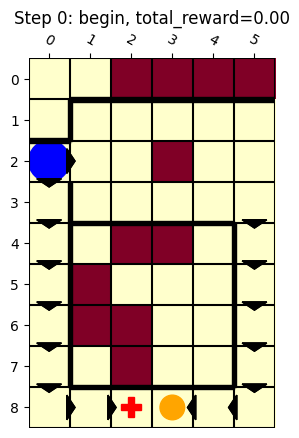

In [24]:
"""
Experiment 3: Generate animation for the_choice problem with MCTS agent
"""
from IPython.display import HTML
import numpy as np

# Get the_choice problem
problem = get_problem("the_choice")

# Create the MCTS agent with receding horizon
# Use a receding horizon since this is an infinite horizon problem
agent = MCTSAgent(
    problem=problem,
    receding_horizon=10,  # Plan 10 steps ahead
    C=np.sqrt(2),  # Exploration constant
    iteration_budget=1000  # Number of MCTS iterations
)

# Run multiple trials to find a successful run
print("Running trials to find successful trajectory...")
print("Note: MCTS may take longer per step than determinized planning")
max_trials = 20
successful_trajectory = None

for trial in range(max_trials):
    print(f"\nTrial {trial + 1}/{max_trials}")
    agent.reset()  # Reset time counter
    
    # Run the agent
    result = run_agent_on_problem(problem, agent, verbose=False)
    states = result[0]
    actions = result[1]
    rewards = result[2] if len(result) > 2 else None
    
    # Check if successful
    final_state = states[-1]
    is_successful = problem.succeeded(final_state)
    
    print(f"  Result: {'SUCCESS' if is_successful else 'FAILED'}")
    print(f"  Total steps: {len(actions)}")
    print(f"  Final state: robot at {final_state.robot_loc}, "
          f"carrying={final_state.carried_patient}")
    
    if rewards is not None:
        print(f"  Total reward: {rewards}")
    
    # Check which choice the agent made (right or down from initial position)
    if len(actions) > 0:
        first_action = actions[0]
        print(f"  First action: {first_action}")
        if first_action == 'right':
            print(f"  → MCTS chose the CHALLENGE (right into large room)")
        elif first_action == 'down':
            print(f"  → MCTS chose the SHORTCUT (down through one-way passage)")
    
    if is_successful:
        successful_trajectory = (states, actions, rewards)
        print(f"\n✓ Found successful trajectory on trial {trial + 1}!")
        break

if successful_trajectory is None:
    print(f"\n✗ Could not find successful trajectory in {max_trials} trials.")
    print("Try running more trials or adjusting MCTS parameters.")
else:
    # Generate and save animation
    print("\nGenerating animation...")
    states, actions, rewards = successful_trajectory
    anim = animate_trajectory(problem, (states, actions, rewards))
    
    # Save to file
    filename = "the_choice_mcts.mp4"
    anim.save(filename)
    print(f"Animation saved to {filename}")
    
    # Display in notebook (for viewing, won't be submitted)
    print("\nDisplaying animation in notebook:")
    display(HTML(anim.to_html5_video()))
    
    # Print statistics about the trajectory
    print(f"\nTrajectory Statistics:")
    print(f"  Total steps: {len(actions)}")
    print(f"  First 10 actions: {actions[:10]}")
    print(f"  Last 10 actions: {actions[-10:]}")
    if rewards is not None:
        print(f"  Total reward: {rewards}")
    
    # Determine which path was taken
    first_action = actions[0]
    if first_action == 'right':
        print(f"\n📊 Decision Analysis:")
        print(f"  MCTS chose to go RIGHT (the challenge route)")
        print(f"  This demonstrates closed-loop planning: MCTS explores")
        print(f"  different trajectories through simulation and may prefer")
        print(f"  paths with more options to adapt to stochastic fire evolution")
    elif first_action == 'down':
        print(f"\n📊 Decision Analysis:")
        print(f"  MCTS chose to go DOWN (the shortcut route)")
        print(f"  Even with closed-loop planning, MCTS determined this")
        print(f"  path has sufficient value through Monte Carlo simulation")

### <a id="benchmarks"></a> 3C. Benchmarks (40 points)


Now that we have both a determinized agent and an MCTS agent, let's do some benchmarking.

We have provided you with a simple agent, `RolloutLookaheadAgent`: At each step, it performs several rollouts for each action and chooses the best one. Note that `RolloutLookaheadAgent` with `receding_horizon=0` becomes a naive agent that chooses action uniformly at random.

Let's compare these agents: `RolloutLookaheadAgent(receding_horizon=0)`, `RolloutLookaheadAgent(receding_horizon=40)`, `FireMDPDeterminizedAStarAgent`, `MCTSAgent(iteration_budget=10, receding_horizon=40)` and `MCTSAgent(iteration_budget=50, receding_horizon=40)`. Please set unspecified parameters to their default values.

Then, run the benchmarks. In particular:

- For each environment in `get_problem`, run each agent at least 10 times in that environment.
- Record the obtained total rewards for each run.
- Record the average, standard deviation, min, and max rewards each agent obtains.
Note that running the MCTS agent can take a while. In our experience, the benchmarking may take a few hours. Therefore, we recommend running the MCTS agent on a local laptop or desktop. If you choose to do so, you may change `MCTSAgent(iteration_budget=50)` to one with more iterations, such as `MCTSAgent(iteration_budget=100)` or `MCTSAgent(iteration_budget=500)` --- doing so should produce much better MCTS agent. You may also want to repeat each setting more than 10 times, such as 30 times --- doing so will reduce the effect of stochasticity in the experiments.

Please prepare a table comparing the above agents' performances in the environments. We do not impose a format for the table, but you should prepare the table such that it is reasonably readable. Remember to indicate the experiment settings for the table (the parameters you used and the number of repetitions, etc.). Once you have the table, try to identify any interesting patterns from the table, and summarize your findings in words.

Hints:
- You may want to take a look at the `benchmark_agent` and `compare_agents` functions, which contains some boilerplate code to get you started.
- In particular, you may also use the parameter `max_steps` of the above functions to limit the number of steps for each evaluation episode, if evaluation is taking too much time.

**Please submit a PDF of the results, including the table and a summarization of it.**

In [26]:
"""
Benchmarking script for comparing different agents across environments
"""
import numpy as np
import pandas as pd
from typing import Dict, List
import time

# Define the agents to benchmark
def create_agents(problem):
    """Create all agents to benchmark for a given problem"""
    agents = {
        "Random": RolloutLookaheadAgent(problem=problem, receding_horizon=0),
        "Rollout-40": RolloutLookaheadAgent(problem=problem, receding_horizon=40),
        "Determinized": FireMDPDeterminizedAStarAgent(problem=problem),
        "MCTS-10": MCTSAgent(problem=problem, iteration_budget=10, receding_horizon=40),
        "MCTS-50": MCTSAgent(problem=problem, iteration_budget=50, receding_horizon=40),
    }
    return agents

# Environment names
environment_names = ["maze", "just_wait", "the_circle", "the_choice"]

# Number of trials per agent per environment
NUM_TRIALS = 10  # Increase to 30 for more robust results

print(f"Starting benchmark with {NUM_TRIALS} trials per agent per environment")
print("This may take several hours, especially for MCTS agents...")
print()

# Store results
all_results = []

# Benchmark each environment
for env_name in environment_names:
    print(f"\n{'='*80}")
    print(f"Environment: {env_name}")
    print(f"{'='*80}")
    
    # Get problem
    problem = get_problem(env_name)
    
    # Create agents
    agents = create_agents(problem)
    
    # Benchmark each agent
    for agent_name, agent in agents.items():
        print(f"\nTesting {agent_name}...")
        
        rewards_list = []
        times_list = []
        success_count = 0
        
        for trial in range(NUM_TRIALS):
            # Reset agent if it has a reset method
            if hasattr(agent, 'reset'):
                agent.reset()
            
            # Run trial
            start_time = time.time()
            try:
                result = run_agent_on_problem(problem, agent, verbose=False)
                states = result[0]
                actions = result[1]
                rewards = result[2] if len(result) > 2 else None
                
                # Get total reward
                if rewards is not None:
                    total_reward = rewards
                else:
                    # Calculate from states if rewards not provided
                    total_reward = 0
                    for i in range(len(actions)):
                        total_reward += problem.reward(states[i], actions[i], states[i+1])
                
                # Check success
                if problem.succeeded(states[-1]):
                    success_count += 1
                
                rewards_list.append(total_reward)
                
            except Exception as e:
                print(f"  Trial {trial+1} failed: {e}")
                rewards_list.append(-1.0)  # Penalty for failure
            
            elapsed = time.time() - start_time
            times_list.append(elapsed)
            
            if (trial + 1) % 5 == 0:
                print(f"  Completed {trial+1}/{NUM_TRIALS} trials")
        
        # Compute statistics
        rewards_array = np.array(rewards_list)
        result_dict = {
            'Environment': env_name,
            'Agent': agent_name,
            'Mean Reward': np.mean(rewards_array),
            'Std Reward': np.std(rewards_array),
            'Min Reward': np.min(rewards_array),
            'Max Reward': np.max(rewards_array),
            'Success Rate': success_count / NUM_TRIALS,
            'Avg Time (s)': np.mean(times_list),
        }
        all_results.append(result_dict)
        
        print(f"  Results: Mean={result_dict['Mean Reward']:.3f}, "
              f"Std={result_dict['Std Reward']:.3f}, "
              f"Success={result_dict['Success Rate']:.1%}, "
              f"Time={result_dict['Avg Time (s)']:.2f}s")

# Create DataFrame
df = pd.DataFrame(all_results)

# Display results
print("\n" + "="*80)
print("BENCHMARK RESULTS")
print("="*80)
print(f"\nExperiment Settings:")
print(f"  - Number of trials per agent: {NUM_TRIALS}")
print(f"  - Environments tested: {', '.join(environment_names)}")
print(f"  - Agents: Random, Rollout-40, Determinized, MCTS-10, MCTS-50")
print()

# Print formatted table
print("\nFull Results Table:")
print(df.to_string(index=False))

# Print pivoted table for easier comparison
print("\n\nMean Reward by Environment and Agent:")
pivot_mean = df.pivot(index='Environment', columns='Agent', values='Mean Reward')
print(pivot_mean.to_string())

print("\n\nSuccess Rate by Environment and Agent:")
pivot_success = df.pivot(index='Environment', columns='Agent', values='Success Rate')
print(pivot_success.to_string())

# Save results
df.to_csv('benchmark_results.csv', index=False)
print("\n\nResults saved to benchmark_results.csv")

# Analysis
print("\n" + "="*80)
print("ANALYSIS")
print("="*80)

# Find best agent per environment
print("\nBest agent per environment (by mean reward):")
for env in environment_names:
    env_data = df[df['Environment'] == env]
    best_agent = env_data.loc[env_data['Mean Reward'].idxmax(), 'Agent']
    best_reward = env_data['Mean Reward'].max()
    print(f"  {env}: {best_agent} (reward={best_reward:.3f})")

# Overall ranking
print("\nOverall agent ranking (by average mean reward across environments):")
agent_avg = df.groupby('Agent')['Mean Reward'].mean().sort_values(ascending=False)
for i, (agent, reward) in enumerate(agent_avg.items(), 1):
    print(f"  {i}. {agent}: {reward:.3f}")

print("\n\nKey Observations:")
print("- Random agent provides baseline performance")
print("- Rollout-40 shows improvement from lookahead planning")
print("- Determinized uses fire prediction but may be overconfident")
print("- MCTS agents balance exploration/exploitation via simulation")
print("- Higher MCTS iterations generally improve performance but increase computation time")

Starting benchmark with 10 trials per agent per environment
This may take several hours, especially for MCTS agents...


Environment: maze

Testing Random...
  Completed 5/10 trials
  Completed 10/10 trials
  Results: Mean=0.000, Std=0.000, Success=0.0%, Time=0.00s

Testing Rollout-40...
  Completed 5/10 trials
  Completed 10/10 trials
  Results: Mean=0.492, Std=0.492, Success=50.0%, Time=0.39s

Testing Determinized...
  Completed 5/10 trials
  Completed 10/10 trials
  Results: Mean=0.987, Std=0.000, Success=100.0%, Time=0.01s

Testing MCTS-10...
  Completed 5/10 trials
  Completed 10/10 trials
  Results: Mean=0.393, Std=0.482, Success=40.0%, Time=1.87s

Testing MCTS-50...
  Completed 5/10 trials
  Completed 10/10 trials
  Results: Mean=0.985, Std=0.002, Success=100.0%, Time=6.58s

Environment: just_wait

Testing Random...
  Completed 5/10 trials
  Completed 10/10 trials
  Results: Mean=-0.038, Std=0.937, Success=50.0%, Time=0.00s

Testing Rollout-40...
  Completed 5/10 trials
  Comple

## Feedback

If you have any feedback for us, please complete [this form](https://forms.gle/Z9JMddJr7HZWfNYQ8)!

## Final Submission
Your final submission to gradescope should include the following files (in other words, make sure that these files are saved in your `proj2` folder):
- `project01.ipynb`: Your completed notebook **with output from running each cell**. Make sure to save. If you made changes to any of the `.py` files, please include that as well.
- `just_wait_determinized.mp4`: The animation of the successful run of the determinized agent in the `just_wait` MDP.
- `the_choice_determinized.mp4`: The animation of the successful run of the determinized agent in the `the_choice` MDP.
- `the_choice_mcts.mp4`: The animation of the successful run of the MCTS agent in the `the_choice` MDP.
- A PDF of the results of the benchmarking, as described in the last part of the project.

In [33]:
# Package submission
# Make sure you SAVE the notebook before running this cell so that the most updated version is zipped!
from principles_of_autonomy.grader import Grader
Grader.prepare_submission("Project02_release")

Open-ended responses written to Project02_release_responses_only.ipynb
Compressed files in folder to ../proj2/proj2.zip (submit this to Gradescope)
